In [3]:
import numpy as np
import spiceypy as spice
from lamberthub import izzo2015
from scipy.optimize import differential_evolution

# -----------------------------------------------------------
# 1. SPICE setup
# -----------------------------------------------------------
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/lsk/naif0012.tls")
spice.furnsh("/Users/rebnoob/Documents/ae105/generic_kernels/spk/planets/de442.bsp")

# -----------------------------------------------------------
# 2. Constants
# -----------------------------------------------------------
MU_SUN   = 132712440041.279   # km^3/s^2
MU_EARTH = 398600.435436
MU_MARS  = 42828.375214

R_EARTH = 6378.1363  # km
R_MARS  = 3396.19    # km

r_park_earth = R_EARTH + 200.0
r_park_mars  = R_MARS  + 200.0

# fixed arrival date (Caltech instructor's birthday trip!)
T_ARR = spice.str2et("2036 APR 05")

# -----------------------------------------------------------
# 3. Helper functions
# -----------------------------------------------------------
def dv_escape_from_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_esc  = np.sqrt(2.0 * mu_body / r_circ)
    v_peri = np.sqrt(v_inf**2 + v_esc**2)
    return v_peri - v_circ

def dv_capture_to_circ(v_inf, mu_body, r_circ):
    v_circ = np.sqrt(mu_body / r_circ)
    v_peri = np.sqrt(v_inf**2 + 2.0 * mu_body / r_circ)
    return v_peri - v_circ

def sun_state(body, et):
    s, _ = spice.spkezr(body, et, "ECLIPJ2000", "NONE", "SUN")
    return np.array(s[:3]), np.array(s[3:6])

# --- Stumpff functions and universal-variable Kepler propagator ---
def stumpff_C(z):
    if z > 0:
        s = np.sqrt(z)
        return (1.0 - np.cos(s)) / z
    elif z < 0:
        s = np.sqrt(-z)
        return (1.0 - np.cosh(s)) / z
    else:
        return 0.5

def stumpff_S(z):
    if z > 0:
        s = np.sqrt(z)
        return (s - np.sin(s)) / (s**3)
    elif z < 0:
        s = np.sqrt(-z)
        return (np.sinh(s) - s) / (s**3)
    else:
        return 1.0 / 6.0

def kepler_propagate(r0, v0, dt, mu):
    """Two-body propagation using universal variables (Vallado-style)."""
    r0n = np.linalg.norm(r0)
    v0n = np.linalg.norm(v0)
    vr0 = np.dot(r0, v0) / r0n
    alpha = 2.0 / r0n - v0n**2 / mu   # 1/a

    # initial guess for x (universal anomaly * sqrt(mu))
    if alpha > 0:
        x = np.sqrt(mu) * alpha * dt
    else:
        # hyperbolic or parabolic-ish
        x = np.sign(dt) * np.sqrt(-1.0 / alpha) * np.log(
            -2.0 * mu * alpha * dt / (vr0 + np.sign(dt) *
            np.sqrt(-mu / alpha) * (1.0 - alpha * r0n))
        )

    for _ in range(60):
        z = alpha * x**2
        C = stumpff_C(z)
        S = stumpff_S(z)
        F = (r0n * vr0 / np.sqrt(mu)) * x**2 * C \
            + (1.0 - alpha * r0n) * x**3 * S \
            + r0n * x - np.sqrt(mu) * dt
        dFdx = (r0n * vr0 / np.sqrt(mu)) * x * (1.0 - z * S) \
               + (1.0 - alpha * r0n) * x**2 * C + r0n
        dx = -F / dFdx
        x += dx
        if abs(dx) < 1e-8:
            break

    z = alpha * x**2
    C = stumpff_C(z)
    S = stumpff_S(z)

    f = 1.0 - x**2 * C / r0n
    g = dt - x**3 * S / np.sqrt(mu)
    r = f * r0 + g * v0
    rn = np.linalg.norm(r)

    fdot = (np.sqrt(mu) / (r0n * rn)) * (z * S - 1.0) * x
    gdot = 1.0 - x**2 * C / rn
    v = fdot * r0 + gdot * v0

    return r, v

def make_vinf_vector(v_inf_mag, alpha, rE, vE):
    """Build in-plane v_inf vector from magnitude and angle (alpha)."""
    t_hat = vE / np.linalg.norm(vE)
    h = np.cross(rE, vE)
    n_hat = np.cross(h, t_hat)
    n_hat /= np.linalg.norm(n_hat)
    return v_inf_mag * (np.cos(alpha) * t_hat + np.sin(alpha) * n_hat)


# -----------------------------------------------------------
# 4. Optional: ballistic fixed-arrival DV (no DSM) for comparison
# -----------------------------------------------------------
def total_dv_ballistic_fixed_arrival(t0):
    """One-impulse Earth departure, Lambert directly to Mars, fixed arrival."""
    tof = T_ARR - t0
    if tof <= 0:
        return 1e6

    rE, vE = sun_state("EARTH Barycenter", t0)
    rM, vM = sun_state("MARS Barycenter", T_ARR)

    # Lambert Earth -> Mars
    v1, v2 = izzo2015(MU_SUN, rE, rM, tof, M=0, prograde=True)

    v_inf_dep = np.linalg.norm(v1 - vE)
    v_inf_arr = np.linalg.norm(v2 - vM)

    dv0 = dv_escape_from_circ(v_inf_dep, MU_EARTH, r_park_earth)
    dv1 = dv_capture_to_circ(v_inf_arr, MU_MARS,  r_park_mars)

    return dv0 + dv1


# -----------------------------------------------------------
# 5. Merit function with DSM (corrected f_DSM handling)
# -----------------------------------------------------------
def total_dv_with_dsm(x):
    """
    x = [t0, v_inf_mag, alpha, f_dsm]
      t0        : departure epoch (ET)
      v_inf_mag : km/s
      alpha     : in-plane angle (rad)
      f_dsm     : fraction of total TOF at which DSM occurs (0..1)
    """
    t0, v_inf_mag, alpha, f_dsm = x

    # total TOF to arrival
    tof_total = T_ARR - t0
    if tof_total <= 0:
        return 1e6

    # allow DSM anywhere between departure and arrival
    # (small epsilon to avoid dt=0)
    eps = 1e-3
    f_dsm = np.clip(f_dsm, eps, 1.0 - eps)
    t_dsm = t0 + f_dsm * tof_total

    # Earth departure state
    rE, vE = sun_state("EARTH Barycenter", t0)
    v_inf_vec = make_vinf_vector(v_inf_mag, alpha, rE, vE)
    r0 = rE.copy()
    v0 = vE + v_inf_vec

    # 1) Departure DV
    dv0 = dv_escape_from_circ(v_inf_mag, MU_EARTH, r_park_earth)

    # 2) Coast to DSM
    dt1 = t_dsm - t0
    if dt1 <= 0:
        return 1e6
    r_dsm, v_minus = kepler_propagate(r0, v0, dt1, MU_SUN)

    # 3) Lambert from DSM to Mars arrival
    rM_arr, vM_arr = sun_state("MARS Barycenter", T_ARR)
    dt2 = T_ARR - t_dsm
    if dt2 <= 0:
        return 1e6

    try:
        v_plus, v_arr = izzo2015(MU_SUN, r_dsm, rM_arr, dt2, M=0, prograde=True)
    except Exception:
        return 1e6  # infeasible geometry

    dv_dsm = np.linalg.norm(v_plus - v_minus)

    v_inf_arr = np.linalg.norm(v_arr - vM_arr)
    dv1 = dv_capture_to_circ(v_inf_arr, MU_MARS, r_park_mars)

    return dv0 + dv_dsm + dv1


# -----------------------------------------------------------
# 6. Optimization setup (note new f_DSM bounds)
# -----------------------------------------------------------
t0_min = spice.str2et("2035 JAN 01")
t0_max = spice.str2et("2036 JAN 15")  # must be before arrival

bounds = [
    (t0_min, t0_max),   # t0
    (0.0, 6.0),         # v_inf magnitude [km/s] (slightly wider bound)
    (-np.pi, np.pi),    # alpha [rad]
    (0.0, 1.0),         # f_DSM (fraction of TOF)
]

result = differential_evolution(
    total_dv_with_dsm,
    bounds,
    tol=1e-4,
    maxiter=120,
    polish=True,
)

best_t0, best_vinf, best_alpha, best_f = result.x
best_tof = (T_ARR - best_t0)
best_t_dsm = best_t0 + best_f * best_tof

print("=== DSM solution ===")
print("Min total DV (km/s):", result.fun)
print("Best departure (TDB):", spice.et2utc(best_t0, "C", 0))
print("Best DSM time (TDB): ", spice.et2utc(best_t_dsm, "C", 0))
print("Fixed arrival (TDB):  ", spice.et2utc(T_ARR, "C", 0))
print("TOF (days):", best_tof / 86400.0)
print("v_inf0 (km/s):", best_vinf)
print("alpha (deg):", np.degrees(best_alpha))
print("f_DSM:", best_f)

# Optional: compare with ballistic fixed-arrival DV at the same departure
dv_ballistic_same_t0 = total_dv_ballistic_fixed_arrival(best_t0)
print("\nBallistic fixed-arrival DV at same t0: {:.4f} km/s".format(dv_ballistic_same_t0))

=== DSM solution ===
Min total DV (km/s): 6.455013812345359
Best departure (TDB): 2035 JUL 03 21:29:18
Best DSM time (TDB):  2035 NOV 11 21:54:41
Fixed arrival (TDB):   2036 APR 05 00:00:00
TOF (days): 276.10465315254476
v_inf0 (km/s): 3.2237348601088467
alpha (deg): -2.3679388120774196
f_DSM: 0.4745216139340253

Ballistic fixed-arrival DV at same t0: 18.6204 km/s


<>:69: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\D'
<>:69: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\D'
/var/folders/qr/bcx422vx5nz170tpkqvf9w540000gn/T/ipykernel_1884/858780951.py:69: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Minimum Total $\Delta V$ with DSM (km/s)")
/var/folders/qr/bcx422vx5nz170tpkqvf9w540000gn/T/ipykernel_1884/858780951.py:70: SyntaxWarning: invalid escape sequence '\D'
  plt.title("Fixed-Arrival Earth→Mars Transfer with DSM\nMin Total $\Delta V$ vs Launch Date")


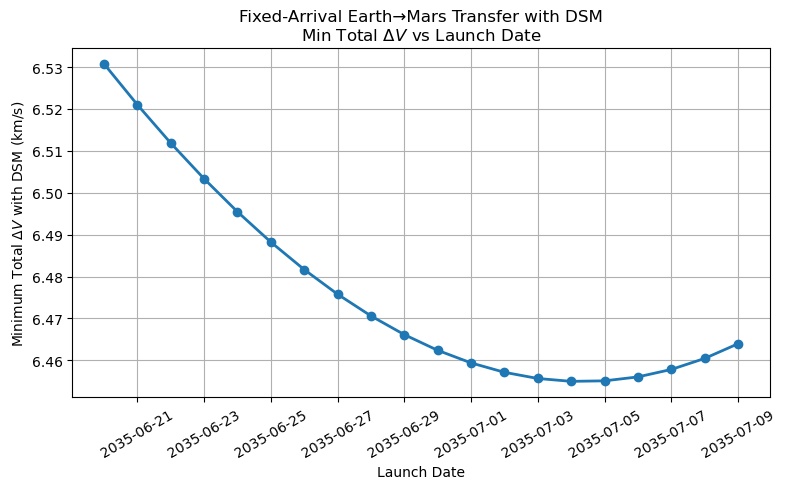

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice
from scipy.optimize import differential_evolution

# -----------------------------------------------------------
# helper: minimize DV for fixed t0 (DSM case)
# -----------------------------------------------------------
def min_dv_for_t0_dsm(t0):
    """
    For a fixed departure time t0, optimize over:
        v_inf_mag, alpha, f_dsm
    and return the minimum total DV and optimal vars.
    """
    bounds_local = [
        (0.0, 5.0),         # v_inf magnitude [km/s]
        (-np.pi, np.pi),    # in-plane angle alpha [rad]
        (0.1, 0.9),         # DSM fraction of total TOF
    ]

    def f_local(y):
        v_inf_mag, alpha, f_dsm = y
        return total_dv_with_dsm([t0, v_inf_mag, alpha, f_dsm])

    res = differential_evolution(
        f_local,
        bounds_local,
        tol=1e-3,
        maxiter=50,
        polish=True,
    )
    return res.fun, res.x   # (min_DV, [v_inf, alpha, f_dsm])


# -----------------------------------------------------------
# sweep a launch period
# -----------------------------------------------------------

start_date = "2035 JUN 20"    # choose whatever start date you want
t0_start = spice.str2et(start_date)
num_days  = 20                # length of launch window
step_days = 1                 # step size

t0_list      = [t0_start + i * 86400.0 * step_days for i in range(num_days)]
dv_min_list  = []
vinf_opt     = []
alpha_opt    = []
fdsm_opt     = []

for t0 in t0_list:
    dv_min, y_opt = min_dv_for_t0_dsm(t0)
    dv_min_list.append(dv_min)
    vinf_opt.append(y_opt[0])
    alpha_opt.append(y_opt[1])
    fdsm_opt.append(y_opt[2])

    """print(f"{spice.et2utc(t0, 'C', 0)}  minDV_DSM={dv_min:.3f} km/s  "
          f"v_inf0={y_opt[0]:.2f} km/s  alpha={np.degrees(y_opt[1]):.1f} deg  f_DSM={y_opt[2]:.2f}")"""

# -----------------------------------------------------------
# plot: min total DV vs departure date (DSM solution)
# -----------------------------------------------------------

dates = [spice.et2datetime(t).date() for t in t0_list]

plt.figure(figsize=(8,5))
plt.plot(dates, dv_min_list, 'o-', lw=2)
plt.xlabel("Launch Date")
plt.ylabel("Minimum Total $\Delta V$ with DSM (km/s)")
plt.title("Fixed-Arrival Earth→Mars Transfer with DSM\nMin Total $\Delta V$ vs Launch Date")
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
